# Working with the RGI files

The glacier outlines obtained from the [Randolph Glacier Inventory](https://www.glims.org/RGI/) are the reference dataset for global and regional applications in OGGM. The current version is V6, and OGGM ships with a slightly modified version which we called `62`.

## Download the glacier outlines 

 To download this version, simply do: 

In [1]:
# this might take a couple of minutes!
from oggm import utils
utils.get_rgi_dir(version='62')  # path to the data after download

'/home/mowglie/disk/OGGM_INPUT/rgi/RGIV62'

## Access a region file

The RGI is divided in 19 regions (and many more sub-regions, not plotted here):

![rgi-map](https://www.researchgate.net/profile/Tobias_Bolch/publication/264125572/figure/fig1/AS:295867740377088@1447551774164/First-order-regions-of-the-RGI-with-glaciers-shown-in-red-Region-numbers-are-those-of.png)
*Source: [the RGI consortium](http://www.glims.org/RGI/randolph60.html)*

In [2]:
from oggm import utils
fr = utils.get_rgi_region_file(11, version='62')  # Central Europe

The RGI region files are [shapefiles](https://en.wikipedia.org/wiki/Shapefile), a vector format commonly used in GIS applications. The library of choice to read shapefiles in python is [geopandas](http://geopandas.org/):

In [3]:
import geopandas as gpd
gdf = gpd.read_file(fr)

## The RGI files and their attributes 

The `gdf` variable is a `GeoDataFrame`, i.e. you can use most of the tools you know from pandas' `DataFrames`:

In [4]:
len(gdf)

3927

In [5]:
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-11.00001,G013599E47495N,20030799,20030999,13.5987,47.4949,11,1,0.122,2191,...,461,0,0,0,0,9,9,None,None,"POLYGON ((13.60035 47.49330, 13.59995 47.49332..."
1,RGI60-11.00002,G013614E47485N,20030799,20030999,13.6135,47.4845,11,1,2.292,2203,...,1853,0,0,0,0,9,9,None,None,"POLYGON ((13.60638 47.47578, 13.60599 47.47579..."
2,RGI60-11.00003,G013596E47484N,20030799,20030999,13.5960,47.4835,11,1,0.851,2280,...,1140,0,0,0,0,9,9,None,None,"POLYGON ((13.59765 47.47613, 13.59726 47.47614..."
3,RGI60-11.00004,G013583E47481N,20030799,20030999,13.5829,47.4807,11,1,0.053,2319,...,382,0,0,0,0,9,9,None,None,"POLYGON ((13.58283 47.47969, 13.58243 47.47971..."
4,RGI60-11.00005,G013603E47477N,20030799,20030999,13.6026,47.4774,11,1,0.057,2656,...,202,0,0,0,0,9,9,None,None,"POLYGON ((13.60076 47.47519, 13.60036 47.47521..."


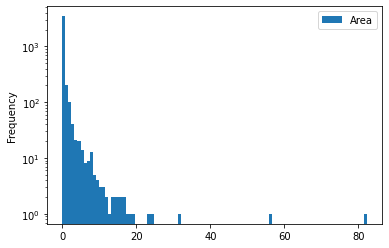

In [6]:
gdf[['Area']].plot(kind='hist', bins=100, logy=True);

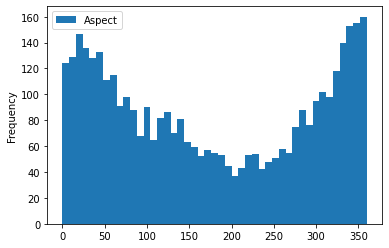

In [7]:
gdf[['Aspect']].plot(kind='hist', bins=45);

## Selecting glaciers per attribute

You may want to select all glaciers in the subregion 2 (Pyrenees):

In [8]:
gdf_sel = gdf.loc[gdf.O2Region == '2']

In [9]:
'Glacier area in the Pyrenees: {} km2'.format(gdf_sel.Area.sum())

'Glacier area in the Pyrenees: 3.183 km2'

## Selecting glaciers in a basin 

Let's use a file shipped with OGGM for a start: 

In [10]:
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

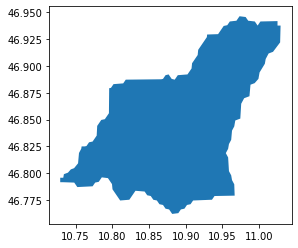

In [11]:
basin.plot();

And select all glaciers within this shape:

In [12]:
import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

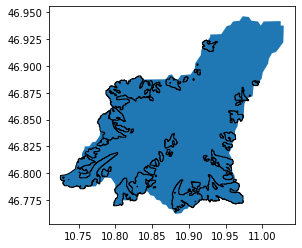

In [13]:
ax = basin.plot();
gdf_sel.plot(ax=ax, edgecolor='k');

## Select glaciers by their ID 

Each glacier in the RGI has a unique ID. It is sometimes difficult to find out which one, but some tools can help you out. For example, the [GLIMS viewer](https://www.glims.org/maps/glims) allows to select glaciers and then see their ID. For example, the Aletsch Glacier in the Swiss Alps:

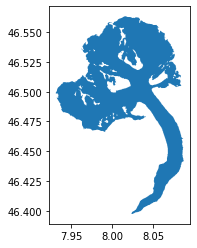

In [14]:
al = utils.get_rgi_glacier_entities(['RGI60-11.01450'], version='62')
al.plot();

## Use the RGI files to start an OGGM run 

RGI files can be given as input to OGGM to make a run:

In [15]:
from oggm import cfg, workflow, tasks
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['border'] = 80
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Rofental', reset=True)

gdirs = workflow.init_glacier_directories(gdf_sel, from_prepro_level=4)

/home/mowglie/disk/Dropbox/HomeDocs/git/oggm-fork/oggm/cfg.py:377: FutureWarning: In future versions of OGGM, the logging config WORKFLOW will no longer print ERROR or WARNING messages, but only high level information (i.e. hiding potential errors in your code but also avoiding cluttered log files for runs with many expected errors, e.g. global runs). If you want to obtain a similar logger behavior as before, set `logging_level='WARNING'`, which will print high level info as well as errors and warnings during the run. If you want to use the new behavior and suppress this warning, set `logging_level='WORKFLOW'` and `future=True`.
  warnings.warn(msg, category=FutureWarning)
2021-01-30 16:16:00: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-01-30 16:16:00: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-01-30 16:16:00: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-01-30 16:16:01: oggm.cfg: PARAM

In [20]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=100,
                             y0=2009, halfsize=10, output_filesuffix='_2000')
ds2000 = utils.compile_run_output(gdirs, filesuffix='_2000')

2021-01-30 16:18:01: oggm.workflow: Execute entity task run_random_climate on 54 glaciers
2021-01-30 16:18:06: oggm.utils: Applying compile_run_output on 54 gdirs.


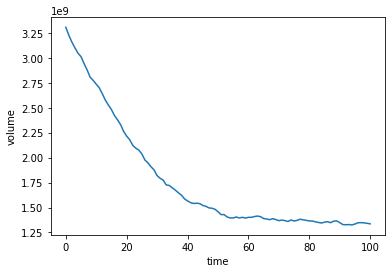

In [21]:
ds2000.sum(dim='rgi_id').volume.plot();

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)